/home/user/miniconda3/envs/regllava_fresh/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-05-15 03:58:51,447] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/user/miniconda3/envs/regllava_fresh/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_audit_symbind_alt@GLIBC_PRIVATE'
/home/user/miniconda3/envs/regllava_fresh/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_catch_exception@GLIBC_PRIVATE'
/home/user/miniconda3/envs/regllava_fresh/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `__nptl_change_stack_perm@GLIBC_PRIVATE'
/home/user/miniconda3/envs/regllava_fresh/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_find_dso_for_object@GLIBC_PRIVATE'
/home/user/miniconda3/envs/regllava_fresh/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `__tunable_is_initialized@GLIBC_PRIVATE'
/home/user/miniconda3/envs/regllava_fresh/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `__tunable_get_val@GLIBC_PRIVATE'
/home/user/miniconda3/envs/regllava_fresh/compiler_compat/ld: 

Loading LLaVA from base model...


You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]
Some weights of LlavaLlamaForCausalLM were not initialized from the model checkpoint at lmsys/vicuna-7b-v1.5 and are newly initialized: ['model.mm_projector.0.bias', 'model.mm_projector.0.weight', 'model.mm_projector.2.bias', 'model.mm_projector.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/user/miniconda3/envs/regllava_fresh/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means 

Determined num_registers: 4
Loading state_dict into CLIP model (strict=False)...
  Unexpected keys: ['visual.fusion_mlp.0.bias', 'visual.fusion_mlp.0.weight', 'visual.fusion_mlp.2.bias', 'visual.fusion_mlp.2.weight', 'visual.proj']
Data type of model.visual.conv1.weight BEFORE explicit convert_weights: torch.float32
  Attempting to convert model weights to torch.bfloat16...
  Successfully converted 490 parameters/buffers to torch.bfloat16.
Data type of model.visual.conv1.weight AFTER explicit convert_weights: torch.bfloat16
[INFO] model loaded → dtype torch.bfloat16, main device cpu
[INFO] loading projector weights from /home/user/Documents/sh_na/projects/neurips/regllava/llava-v1.5-7b-local/mm_projector.bin
[INFO] LLaVA model explicitly moved to cuda. Main param device: cuda:0
[INFO] Projector (first layer) device: cuda:0
[INFO] Vision tower (CLIPVisionTower module) effective device: cuda
[INFO] Vision tower internal model (e.g., conv1) device: cuda:0


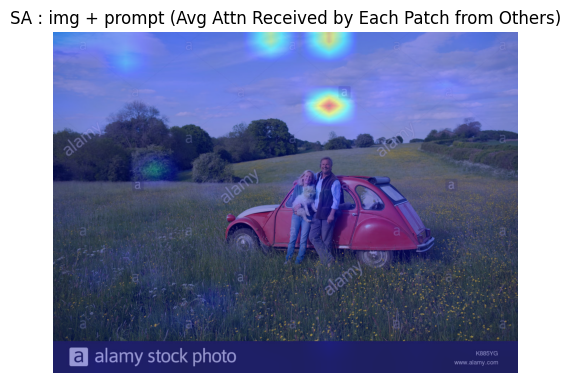


[USER] What is the woman holding in the image?
[ASSISTANT] The woman in the image is holding a camera.

--- Debug 5-C: Input Preparation ---
Shape of final_sequence_for_attn_ids: torch.Size([1, 63])
Shape of prepared_inputs_embeds: torch.Size([1, 318, 4096])
Shape of prepared_attention_mask: torch.Size([1, 318])
Expected embedded sequence length: 318
Shape of attention map (after head mean): torch.Size([318, 318])
--- Debug 5-C: Indexing ---
Image feature block in attention map: [35, 291)
PROMPT_TXT query token block in attention map: [291, 307)
Shape of extracted attention slice: torch.Size([16, 256])


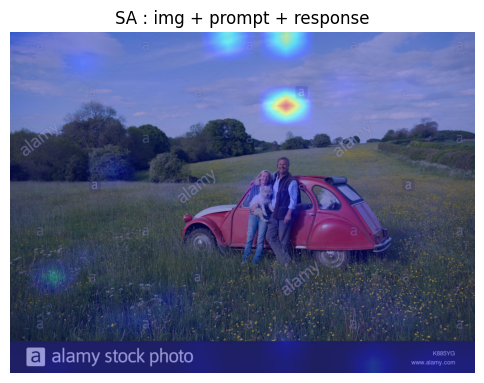


--- Section 5-D: Visualizing Vision Tower Internal Self-Attention ---
Shape of attentions_from_selected_vit_layer_all_heads (num_heads, seq, seq): torch.Size([1, 261, 261])
Visualizing Vision Tower Layer 23/23
Num Patches: 256, Num Registers: 4
Patch tokens in ViT attention map: range [5, 261)
Shape of mean attention map for selected ViT layer (should be 2D HxW): torch.Size([261, 261])


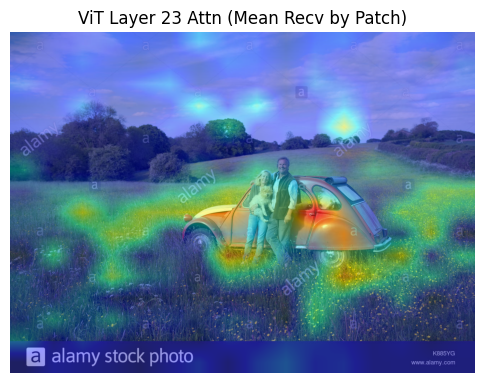

In [1]:
# llava_run_inference.py
# ------------------------------------------------------------
# 0. 기본 환경 세팅
# ------------------------------------------------------------
# import getpass
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.4"
os.environ["LD_LIBRARY_PATH"] = (
    "/usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.4/lib64:"
    + os.environ.get("LD_LIBRARY_PATH", "")
)
# password = getpass.getpass()
# command = "sudo -S apt update"
# os.system('echo %s | %s' % (password, command))
# command = "sudo -S apt install -y build-essential g++ gcc make ninja-build"
# os.system('echo %s | %s' % (password, command))


import json, os, sys, math, warnings
from pathlib import Path
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np, cv2
from PIL import Image
from io import BytesIO
import requests

from transformers import TextStreamer
from llava.constants import (
    IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
)
from llava.conversation import conv_templates
from llava.utils import disable_torch_init
from llava.mm_utils import (
    process_images, tokenizer_image_token, get_model_name_from_path
)
from llava.model.builder import load_pretrained_model

# ------------------------------------------------------------
# 1. 사용자 파라미터
# ------------------------------------------------------------
ROOT = Path().cwd()                             # 스크립트 위치
MODEL_DIR   = ROOT / "llava-v1.5-7b-local"      # ← config, projector 위치
BASE_LLM    = "lmsys/vicuna-7b-v1.5"            # Vicuna‑7B
IMAGE_PATH  = ROOT / "data/car.jpg"
PROMPT_TXT  = "What is the woman holding in the image?"

DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
MAX_TOKENS  = 256
TEMPERATURE = 0.2
VISUALIZE   = True          # heat‑map on/off

# ------------------------------------------------------------
# 2. 모델 로드
# ------------------------------------------------------------
disable_torch_init()

model_name = get_model_name_from_path(str(MODEL_DIR))
tokenizer, model, image_processor, _ctx_len = load_pretrained_model(
    str(MODEL_DIR),
    model_base = BASE_LLM,
    model_name = model_name,
    # device_map = "auto",
    device_map = "cuda",
    attn_implementation = "eager",
    torch_dtype = torch.bfloat16
)
main_device = next(model.parameters()).device
print(f"[INFO] model loaded → dtype {model.dtype}, main device {main_device}")

# projector 추가 로딩 여부
cfg_path = MODEL_DIR / "config.json"
with open(cfg_path, "r") as f:
    cfg_json = json.load(f)

proj_path = MODEL_DIR / "mm_projector.bin"
if cfg_json.get("use_mm_proj", True) and proj_path.exists():
    print(f"[INFO] loading projector weights from {proj_path}")
    proj_state = torch.load(proj_path, map_location="cpu")
    # 키 필터링
    proj_state = {k.split("mm_projector.",1)[-1]: v.to(model.dtype) 
                  for k,v in proj_state.items() if "mm_projector" in k}
    model.get_model().mm_projector.load_state_dict(proj_state, strict=False)


# ------------------------------------------------------------
# 3. 이미지 전처리
# ------------------------------------------------------------
def load_image(path_or_url:str)->Image.Image:
    if str(path_or_url).startswith(("http://","https://")):
        buf = requests.get(path_or_url, timeout=10); buf.raise_for_status()
        return Image.open(BytesIO(buf.content)).convert("RGB")
    return Image.open(path_or_url).convert("RGB")

pil_img   = load_image(IMAGE_PATH)
orig_size = pil_img.size
img_tensor= process_images([pil_img], image_processor, model.config)
if not isinstance(img_tensor, list): img_tensor=[img_tensor]
img_tensor = [t.to(main_device, dtype=model.dtype) for t in img_tensor]


# After model and projector loading
model.to(DEVICE)
print(f"[INFO] LLaVA model explicitly moved to {DEVICE}. Main param device: {next(model.parameters()).device}")


# Access the first layer of the mm_projector (assuming it's an nn.Linear or similar with a weight)
# and get its weight's device.
# model.get_model().mm_projector is an nn.Sequential
# The config.json shows "mm_projector_type": "mlp2x_gelu",
# which means it's typically [Linear, GELU, Linear]. So, the first Linear is at index 0.
if isinstance(model.get_model().mm_projector, torch.nn.Sequential) and len(model.get_model().mm_projector) > 0:
    # Try to get the weight of the first learnable module in the projector
    first_proj_layer_with_weight = None
    for layer in model.get_model().mm_projector:
        if hasattr(layer, 'weight') and isinstance(layer.weight, torch.nn.Parameter):
            first_proj_layer_with_weight = layer
            break
    
    if first_proj_layer_with_weight is not None:
        print(f"[INFO] Projector (first layer) device: {first_proj_layer_with_weight.weight.device}")
    else:
        print("[INFO] Projector does not seem to have a layer with a 'weight' attribute (e.g., all non-parametric layers).")
else:
    print("[INFO] Projector is not an nn.Sequential or is empty.")


# Ensure vision tower also reports correct device (it should already be on CUDA from builder.py logic)
vision_tower_module = model.get_vision_tower()
if vision_tower_module.is_loaded:
    print(f"[INFO] Vision tower (CLIPVisionTower module) effective device: {vision_tower_module.device}")
    print(f"[INFO] Vision tower internal model (e.g., conv1) device: {vision_tower_module.vision_tower.conv1.weight.device}")

# Ensure image_tensor is on the same device
img_tensor = [t.to(DEVICE, dtype=model.dtype) for t in img_tensor]

# ------------------------------------------------------------
# 4. 프롬프트 작성 & 토크나이즈
# ------------------------------------------------------------
conv_key = next((k for k in conv_templates if k in model_name.lower()),
                "llava_v1")
conv = conv_templates[conv_key].copy()

if model.config.mm_use_im_start_end:
    user_prompt = f"{DEFAULT_IM_START_TOKEN}{DEFAULT_IMAGE_TOKEN}{DEFAULT_IM_END_TOKEN}\n{PROMPT_TXT}"
else:
    user_prompt = f"{DEFAULT_IMAGE_TOKEN}\n{PROMPT_TXT}"
conv.append_message(conv.roles[0], user_prompt)
conv.append_message(conv.roles[1], None)
full_prompt = conv.get_prompt()

input_ids = tokenizer_image_token(
    full_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt"
).unsqueeze(0).to(main_device)
attention_mask = torch.ones_like(input_ids)

assert (input_ids==IMAGE_TOKEN_INDEX).sum() > 0, "<image> 토큰 누락!"

# ------------------------------------------------------------
# 5‑A.  이미지 자체 어텐션 heat‑map
# ------------------------------------------------------------
if VISUALIZE:
    with torch.no_grad():
        outs_A = model(
            input_ids=input_ids,
            images=img_tensor,
            image_sizes=[orig_size],
            output_attentions=True,
            return_dict=True
        )
    
    attn_map_A_all_heads = outs_A.attentions[-1][0].cpu() # (num_heads, seq_len, seq_len)
    attn_map_A = attn_map_A_all_heads.mean(dim=0) # 헤드에 대해 평균 (seq_len, seq_len)
    actual_total_seq_len_A = attn_map_A.shape[0]

    # --- Vision Tower 및 LLaVA 설정 기반 이미지 피처 정보 ---
    num_patches = model.get_vision_tower().num_patches # 예: 256

    # LLaVA가 최종적으로 LLM에 입력하는 이미지 피처의 수
    num_features_for_llm_input = num_patches 

    # --- 어텐션 맵 인덱싱 ---
    img_token_idx_in_prompt = (input_ids[0] == IMAGE_TOKEN_INDEX).nonzero(as_tuple=True)[0].item()
    img_feature_block_start_A = img_token_idx_in_prompt 
    
    num_img_features_in_attn_A = actual_total_seq_len_A - (input_ids.shape[1] - 1)

    if num_img_features_in_attn_A == num_features_for_llm_input:
        patches_abs_start_A = img_feature_block_start_A
        patches_abs_end_A = img_feature_block_start_A + num_features_for_llm_input
        
        # 수정: 각 패치가 다른 모든 패치로부터 받는 평균 어텐션 (수신 관점)
        # (num_features, num_features) 형태의 이미지 피처 간 어텐션 행렬
        patch_self_attn_matrix_A = attn_map_A[patches_abs_start_A:patches_abs_end_A, patches_abs_start_A:patches_abs_end_A]
        
        # 각 패치(열 인덱스, key)가 다른 모든 패치(행 인덱스, query)로부터 받는 어텐션의 평균 (dim=0은 query 차원에 대한 평균)
        avg_attn_received_by_each_patch_A = patch_self_attn_matrix_A.mean(dim=0) # shape: (num_features_for_llm_input,)

        if avg_attn_received_by_each_patch_A.shape[0] == num_features_for_llm_input:
            if num_features_for_llm_input > 0 and math.isqrt(num_features_for_llm_input)**2 == num_features_for_llm_input:
                side = int(math.sqrt(num_features_for_llm_input))
                patch_attn_grid_A = avg_attn_received_by_each_patch_A.float().reshape(side, side)

                heatmap_A_interpolated = torch.nn.functional.interpolate(
                    patch_attn_grid_A.unsqueeze(0).unsqueeze(0),
                    size=pil_img.size[::-1], mode="bilinear", align_corners=False
                )[0, 0].numpy()

                base_bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
                plt.figure(figsize=(6,6))
                plt.title(f"SA : img + prompt (Avg Attn Received by Each Patch from Others)")
                heatmap_A_norm = (heatmap_A_interpolated - heatmap_A_interpolated.min()) / (heatmap_A_interpolated.ptp() + 1e-8)
                heatmap_A_colored_bgr = cv2.applyColorMap((heatmap_A_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
                mixed_A_bgr = cv2.addWeighted(base_bgr, 0.6, heatmap_A_colored_bgr, 0.4, 0)
                plt.imshow(cv2.cvtColor(mixed_A_bgr, cv2.COLOR_BGR2RGB)); plt.axis("off")
                plt.show()
            else:
                print(f"[5-A] Num features ({num_features_for_llm_input}) not a perfect square for grid.")
        else:
            print(f"[5-A] Extracted patch attention vector size {avg_attn_received_by_each_patch_A.shape[0]} != {num_features_for_llm_input}.")
    else:
        print(f"[5-A] Num image features in attention map ({num_img_features_in_attn_A}) "
              f"does not match expected ({num_features_for_llm_input}).")

# ------------------------------------------------------------
# 5‑B. 텍스트 생성 
# (이 부분은 변경 없음)
# ------------------------------------------------------------
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
gen_kwargs = dict(
    inputs            = input_ids,
    attention_mask    = attention_mask,
    images            = img_tensor,
    image_sizes       = [orig_size],
    do_sample         = TEMPERATURE>0,
    temperature       = TEMPERATURE,
    max_new_tokens    = MAX_TOKENS,
    streamer          = streamer,
    pad_token_id      = tokenizer.pad_token_id or tokenizer.eos_token_id,
    output_attentions = True,
    return_dict_in_generate=True
)
print(f"\n[USER] {PROMPT_TXT}\n[ASSISTANT] ", end='', flush=True)
with torch.inference_mode():
    gen_out = model.generate(**gen_kwargs)

# ------------------------------------------------------------
# 5‑C. 텍스트→이미지 cross‑attention heat‑map
# ------------------------------------------------------------
if VISUALIZE:
    # --- 최종 입력 ID 시퀀스 준비 ---
    # input_ids: 원본 프롬프트 (IMAGE_TOKEN_INDEX 포함)
    # generated_ids: 생성된 텍스트 부분
    generated_ids_from_generate = gen_out.sequences
    if generated_ids_from_generate.shape[0] > 1: # 배치 크기 1로 가정
        generated_ids_from_generate = generated_ids_from_generate[0:1]
    generated_ids = generated_ids_from_generate.to(input_ids.device)
    
    # final_sequence_for_attn_ids: <IMAGE_TOKEN_INDEX>가 포함된 전체 토큰 ID 시퀀스
    final_sequence_for_attn_ids = torch.cat([input_ids, generated_ids], dim=1).to(main_device)

    print(f"\n--- Debug 5-C: Input Preparation ---")
    print(f"Shape of final_sequence_for_attn_ids: {final_sequence_for_attn_ids.shape}")

    # --- 1. 모델 입력 임베딩 및 어텐션 마스크 생성 ---
    # prepare_inputs_labels_for_multimodal: <IMAGE_TOKEN_INDEX>를 이미지 임베딩으로 대체
    (
        _, prepared_position_ids, prepared_attention_mask, _,
        prepared_inputs_embeds, _
    ) = model.prepare_inputs_labels_for_multimodal(
        input_ids=final_sequence_for_attn_ids,
        position_ids=None,
        attention_mask=torch.ones_like(final_sequence_for_attn_ids), # 임시 마스크
        past_key_values=None, labels=None,
        images=img_tensor, image_sizes=[orig_size]
    )

    print(f"Shape of prepared_inputs_embeds: {prepared_inputs_embeds.shape}")
    if prepared_attention_mask is not None:
        print(f"Shape of prepared_attention_mask: {prepared_attention_mask.shape}")

    num_llm_image_features = model.get_vision_tower().num_patches # 순수 패치 수
    # mm_vision_select_feature가 'cls_patch'면 +1 해야 하지만, 현재 설정은 'patch'
    
    # 임베딩된 시퀀스 길이 예상: (토큰 ID 길이 - 1) + 이미지 피처 수
    expected_embed_seq_len = (final_sequence_for_attn_ids.shape[1] - 1) + num_llm_image_features
    print(f"Expected embedded sequence length: {expected_embed_seq_len}")
    if prepared_inputs_embeds.shape[1] != expected_embed_seq_len:
        print(f"[ERROR] Mismatch in embedded sequence length. Aborting 5-C.")
        # exit() # 또는 이 블록을 건너뛰도록 처리

    # --- 2. 모델 직접 호출하여 어텐션 계산 ---
    # input_ids 대신 prepared_inputs_embeds 사용, images는 이미 반영됨
    with torch.no_grad():
        outs_C = model(
            inputs_embeds=prepared_inputs_embeds,
            attention_mask=prepared_attention_mask, # prepare_inputs_... 에서 얻은 마스크 사용
            output_attentions=True, return_dict=True
        )
    
    # 어텐션 맵: 마지막 레이어, 헤드 평균
    attn_map_C = outs_C.attentions[-1][0].cpu().mean(dim=0)
    actual_embed_seq_len_in_attn = attn_map_C.shape[0]
    print(f"Shape of attention map (after head mean): {attn_map_C.shape}")
    if actual_embed_seq_len_in_attn != expected_embed_seq_len:
        print(f"[ERROR] Mismatch between attention map length and expected embed length. Aborting 5-C.")
        # exit()

    # --- 3. 어텐션 맵 인덱싱 ---
    # 모든 인덱스는 임베딩된 시퀀스(어텐션 맵) 기준
    img_token_marker_idx_in_input_ids = (input_ids[0] == IMAGE_TOKEN_INDEX).nonzero(as_tuple=True)[0].item()

    # 이미지 피처 블록: <IMAGE_TOKEN_INDEX> 위치부터 시작
    img_feature_start_idx = img_token_marker_idx_in_input_ids
    img_feature_end_idx = img_feature_start_idx + num_llm_image_features

    # PROMPT_TXT 쿼리 토큰 블록: 이미지 피처 블록 바로 다음부터, 원본 input_ids의 PROMPT_TXT 길이만큼
    prompt_txt_token_count = input_ids.shape[1] - (img_token_marker_idx_in_input_ids + 1)
    query_text_start_idx = img_feature_end_idx
    query_text_end_idx = query_text_start_idx + prompt_txt_token_count
    
    # 인덱스 유효범위 클리핑 (안전장치)
    img_feature_end_idx = min(img_feature_end_idx, actual_embed_seq_len_in_attn)
    query_text_end_idx = min(query_text_end_idx, actual_embed_seq_len_in_attn)

    print(f"--- Debug 5-C: Indexing ---")
    print(f"Image feature block in attention map: [{img_feature_start_idx}, {img_feature_end_idx})")
    print(f"PROMPT_TXT query token block in attention map: [{query_text_start_idx}, {query_text_end_idx})")
    
    # --- 4. 히트맵 생성 ---
    valid_query = query_text_start_idx < query_text_end_idx
    valid_key = img_feature_start_idx < img_feature_end_idx and num_llm_image_features > 0
    
    if valid_query and valid_key:
        # text_to_image_attentions_C: (PROMPT_TXT 토큰 수, 이미지 피처 수)
        text_to_image_attentions_C = attn_map_C[query_text_start_idx:query_text_end_idx, 
                                                img_feature_start_idx:img_feature_end_idx]
        print(f"Shape of extracted attention slice: {text_to_image_attentions_C.shape}")

        if text_to_image_attentions_C.numel() > 0 and \
           text_to_image_attentions_C.shape[1] == num_llm_image_features: # 키(이미지 피처) 차원 일치 확인
            
            mean_attn_to_patches = text_to_image_attentions_C.mean(dim=0) # 각 이미지 패치에 대한 평균 어텐션

            if mean_attn_to_patches.shape[0] == num_llm_image_features and \
               math.isqrt(num_llm_image_features)**2 == num_llm_image_features: # 제곱수 확인
                
                side = int(math.sqrt(num_llm_image_features))
                grid = mean_attn_to_patches.float().reshape(side, side)
                
                heatmap_interpolated = torch.nn.functional.interpolate(
                    grid.unsqueeze(0).unsqueeze(0),
                    size=pil_img.size[::-1], mode="bilinear", align_corners=False
                )[0, 0].numpy()

                base_bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
                plt.figure(figsize=(6,6))
                plt.title(f"SA : img + prompt + response") ################################### 여기서 계산되는 거 avg attn 맞는지 체크 필요함
                norm_heatmap = (heatmap_interpolated - heatmap_interpolated.min()) / \
                               (heatmap_interpolated.ptp() + 1e-8)
                colored_heatmap = cv2.applyColorMap((norm_heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
                mixed_img = cv2.addWeighted(base_bgr, 0.6, colored_heatmap, 0.4, 0)
                plt.imshow(cv2.cvtColor(mixed_img, cv2.COLOR_BGR2RGB)); plt.axis("off")
                plt.show()
            else:
                print(f"[5-C] Cannot create grid: num_features ({num_llm_image_features}) not a perfect square or shape mismatch.")
        else:
            print(f"[5-C] Extracted attention slice is empty or key dimension mismatch.")
    else:
        print(f"[5-C] Invalid query or key block for heatmap. Valid query: {valid_query}, Valid key: {valid_key}")


# ------------------------------------------------------------
# 5‑D. Vision Tower 내부 셀프 어텐션 시각화
# ------------------------------------------------------------
if VISUALIZE: # VISUALIZE 플래그가 True일 때만 실행
    print("\n--- Section 5-D: Visualizing Vision Tower Internal Self-Attention ---")
    
    vision_tower_module = model.get_vision_tower()

    if not vision_tower_module.is_loaded:
        print("[5-D] Vision Tower is not loaded. Skipping visualization.")
    else:
        current_image_batch_for_vit = None # 미리 None으로 초기화

        # img_tensor는 [(B,C,H,W)] 형태의 리스트로 가정 (요소 1개)
        if not img_tensor: # img_tensor 리스트가 비어있는 경우
            print("[5-D] img_tensor list is empty. Skipping.")
        elif not isinstance(img_tensor[0], torch.Tensor): # 첫번째 요소가 텐서가 아닌 경우
            print(f"[5-D] First item in img_tensor list is not a Tensor (type: {type(img_tensor[0])}). Skipping.")
        else:
            # img_tensor[0]은 (B,C,H,W) 형태의 텐서
            # 시각화를 위해 첫 번째 배치 아이템만 사용 (1,C,H,W)
            batch_tensor_from_list = img_tensor[0] 
            if batch_tensor_from_list.ndim == 4 and batch_tensor_from_list.shape[0] >= 1:
                current_image_batch_for_vit = batch_tensor_from_list[0:1] # (1,C,H,W)
            elif batch_tensor_from_list.ndim == 3: # 만약 (C,H,W) 형태로 들어왔다면 (B=1이 생략된 경우)
                current_image_batch_for_vit = batch_tensor_from_list.unsqueeze(0) # (1,C,H,W)
            else:
                print(f"[5-D] Tensor in img_tensor[0] has unexpected ndim: {batch_tensor_from_list.ndim}. Skipping.")

        if current_image_batch_for_vit is not None:
            try:
                # CLIPVisionTower.forward 호출하여 어텐션 가중치 요청
                with torch.no_grad():
                    vision_tower_output = vision_tower_module.forward(
                        current_image_batch_for_vit, # (1, C, H, W) 형태의 텐서
                        output_attentions_for_visualization=True
                    )
                
                if isinstance(vision_tower_output, tuple) and len(vision_tower_output) == 2:
                    vit_attentions_tuple = vision_tower_output[1]

                    if vit_attentions_tuple is None:
                        print("[5-D] Vision Tower did not return attention weights.")
                    else:
                        num_vit_layers = len(vit_attentions_tuple)
                        if num_vit_layers == 0:
                            print("[5-D] Vision Tower returned an empty tuple for attentions.")
                        else:
                            vit_layer_idx_to_visualize = num_vit_layers - 1 

                            attentions_one_layer_vit_all_heads_raw = vit_attentions_tuple[vit_layer_idx_to_visualize]
                            
                            attentions_from_selected_vit_layer_all_heads = None
                            if attentions_one_layer_vit_all_heads_raw.ndim == 4 and attentions_one_layer_vit_all_heads_raw.shape[0] == 1:
                                attentions_from_selected_vit_layer_all_heads = attentions_one_layer_vit_all_heads_raw[0].cpu()
                            elif attentions_one_layer_vit_all_heads_raw.ndim == 3: # (num_heads, seq, seq)
                                attentions_from_selected_vit_layer_all_heads = attentions_one_layer_vit_all_heads_raw.cpu()
                            else:
                                print(f"[5-D ERROR] Unexpected shape for raw attentions from ViT layer: "
                                      f"{attentions_one_layer_vit_all_heads_raw.shape}. Skipping.")
                            
                            if attentions_from_selected_vit_layer_all_heads is not None:
                                print(f"Shape of attentions_from_selected_vit_layer_all_heads (num_heads, seq, seq): "
                                      f"{attentions_from_selected_vit_layer_all_heads.shape}")

                                if attentions_from_selected_vit_layer_all_heads.ndim != 3:
                                    print(f"[5-D ERROR] Expected 3D tensor (num_heads, seq_len, seq_len) for head averaging, "
                                          f"got {attentions_from_selected_vit_layer_all_heads.ndim}D. Skipping.")
                                else:
                                    mean_attention_selected_vit_layer = attentions_from_selected_vit_layer_all_heads.mean(dim=0)
                                    
                                    num_registers_in_vit = vision_tower_module.num_registers
                                    num_patches_in_vit = vision_tower_module.num_patches

                                    patch_start_index_in_vit_attn = 1 + num_registers_in_vit
                                    patch_end_index_in_vit_attn = patch_start_index_in_vit_attn + num_patches_in_vit
                                    
                                    print(f"Visualizing Vision Tower Layer {vit_layer_idx_to_visualize}/{num_vit_layers -1}")
                                    print(f"Num Patches: {num_patches_in_vit}, Num Registers: {num_registers_in_vit}")
                                    print(f"Patch tokens in ViT attention map: range [{patch_start_index_in_vit_attn}, {patch_end_index_in_vit_attn})")
                                    print(f"Shape of mean attention map for selected ViT layer (should be 2D HxW): {mean_attention_selected_vit_layer.shape}")

                                    if mean_attention_selected_vit_layer.ndim != 2:
                                        print(f"[5-D ERROR] mean_attention_selected_vit_layer is not 2D as expected "
                                              f"(shape: {mean_attention_selected_vit_layer.shape}). Cannot perform 2D slicing. Skipping.")
                                    elif not (patch_end_index_in_vit_attn <= mean_attention_selected_vit_layer.shape[0] and \
                                              patch_end_index_in_vit_attn <= mean_attention_selected_vit_layer.shape[1] and \
                                              patch_start_index_in_vit_attn < patch_end_index_in_vit_attn and \
                                              num_patches_in_vit > 0) :
                                        print(f"[5-D] Patch indices are out of bounds for the ViT attention map "
                                              f"(Map Size: {mean_attention_selected_vit_layer.shape}, "
                                              f"Patch End Index: {patch_end_index_in_vit_attn}). Or num_patches_in_vit is 0. Skipping.")
                                    else:
                                        patch_to_patch_attention_matrix = mean_attention_selected_vit_layer[
                                            patch_start_index_in_vit_attn:patch_end_index_in_vit_attn,
                                            patch_start_index_in_vit_attn:patch_end_index_in_vit_attn
                                        ]
                                        avg_attention_received_by_each_patch = patch_to_patch_attention_matrix.mean(dim=0)

                                        if avg_attention_received_by_each_patch.shape[0] == num_patches_in_vit and \
                                           (num_patches_in_vit > 0 and math.isqrt(num_patches_in_vit)**2 == num_patches_in_vit):
                                            
                                            side_length = int(math.sqrt(num_patches_in_vit))
                                            attention_grid_for_patches = avg_attention_received_by_each_patch.float().reshape(side_length, side_length)
                                            
                                            heatmap_interpolated_vit = torch.nn.functional.interpolate(
                                                attention_grid_for_patches.unsqueeze(0).unsqueeze(0),
                                                size=pil_img.size[::-1], 
                                                mode="bilinear",
                                                align_corners=False
                                            )[0, 0].numpy()

                                            if 'base_bgr' not in locals() or base_bgr is None:
                                                base_bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
                                            
                                            plt.figure(figsize=(6,6))
                                            plt.title(f"ViT Layer {vit_layer_idx_to_visualize} Attn (Mean Recv by Patch)")
                                            
                                            norm_heatmap_vit = (heatmap_interpolated_vit - heatmap_interpolated_vit.min()) / \
                                                               (heatmap_interpolated_vit.ptp() + 1e-8)
                                            colored_heatmap_vit = cv2.applyColorMap((norm_heatmap_vit * 255).astype(np.uint8), cv2.COLORMAP_JET)
                                            
                                            mixed_image_vit = cv2.addWeighted(base_bgr, 0.6, colored_heatmap_vit, 0.4, 0)
                                            plt.imshow(cv2.cvtColor(mixed_image_vit, cv2.COLOR_BGR2RGB))
                                            plt.axis("off")
                                            plt.show()
                                        else:
                                            print(f"[5-D] Number of patches ({num_patches_in_vit}) is not a perfect square or shape mismatch for grid.")
                else:
                    print("[5-D] CLIPVisionTower.forward did not return a tuple of (features, attentions) as expected.")
            except Exception as e:
                print(f"[ERROR in 5-D] Failed to visualize Vision Tower internal attention: {e}")
                import traceback
                traceback.print_exc()
        else: 
            print("[5-D] current_image_batch_for_vit is None. Skipping ViT attention visualization.")